In [1]:
import tensorflow as tf
tf.enable_eager_execution()

!sudo rm -f /etc/boto.cfg
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

import saving_train
import loading_ds_train

import loading_ds_test
import saving_test

In [2]:
## Must be openslide version 3.4.1
from openslide import open_slide, __library_version__ as openslide_version
print(openslide_version)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

3.4.1


In [3]:
## Optional: remove sliced images from directory if necessary
# !rm -r 'data/091'
# !rm -r 'data/094'

In [24]:
training_image_path_list = ['tumor_094.tif',
                            'tumor_091.tif',
                            'tumor_031.tif',
                            'tumor_078.tif',
                            'tumor_081.tif',
                            'tumor_064.tif',
                            'tumor_035.tif',
                            'tumor_075.tif',
                            'tumor_019.tif',
                            'tumor_084.tif',
                            'tumor_012.tif',
                            'tumor_059.tif']

validation_image_path_list = ['tumor_101.tif',
                              'tumor_023.tif',
                              'tumor_091.tif',
                              'tumor_110.tif']

testing_image_path_list = ['tumor_038.tif',
                           'tumor_094.tif',
                           'tumor_057.tif',
                           'tumor_078.tif']

In [25]:
saving_train.train_part_1(training_image_path_list, num_pixels = 64, num_level = 3)

tumor_094.tif tumor_094_mask.tif
tumor_091.tif tumor_091_mask.tif
tumor_031.tif tumor_031_mask.tif
tumor_078.tif tumor_078_mask.tif
tumor_081.tif tumor_081_mask.tif
tumor_064.tif tumor_064_mask.tif
tumor_035.tif tumor_035_mask.tif
tumor_075.tif tumor_075_mask.tif
tumor_019.tif tumor_019_mask.tif
tumor_084.tif tumor_084_mask.tif
tumor_012.tif tumor_012_mask.tif
tumor_059.tif tumor_059_mask.tif


In [26]:
saving_train.save_second_level(training_image_path_list, input_level = 3, num_input_pixels = 64, 
                                                       output_level = 4, num_output_pixels = 64)

In [27]:
ds_train, steps_per_epoch_train = loading_ds_train.train_part_2(training_image_path_list, num_level_1 = 3,num_level_2=4 )

In [28]:
print(steps_per_epoch_train)

3278


In [29]:
## Imagenet bases using model subclassing
class dense_conv_split_model(tf.keras.Model):

    def __init__(self):
        super(dense_conv_split_model, self).__init__(name='dense_conv_split_model')

#         conv_base = tf.keras.applications.VGG16(weights='imagenet',
#                                                 include_top=False)#,
#                                                 #input_shape=(128, 128, 3))
            
        conv_base = tf.keras.applications.xception.Xception(include_top=False,
                                                        weights='imagenet',
                                                        classes=2)

            
            
        conv_base.trainable = False

        self.cnn1 = conv_base
        self.model1_flatten1  = tf.keras.layers.Flatten()

        self.cnn2 = conv_base
        self.model2_flatten2 = tf.keras.layers.Flatten()

        self.merge_layer = tf.layers.Dense(32, activation='relu')
        self.final = tf.layers.Dense(2, activation='softmax')

    def call(self, x):
        x1, x2 = x[0], x[1]

        x1 = self.cnn1(x1)
        x1 = self.model1_flatten1(x1)

        x2 = self.cnn2(x2)
        x2 = self.model2_flatten2(x2)

        x = tf.concat([x1, x2], 1)
        x = self.merge_layer(x)
        x = self.final(x)

        return x

In [30]:
model = dense_conv_split_model()

In [31]:
## Compile and train model
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['acc'])

history = model.fit(ds_train, epochs=10, steps_per_epoch=steps_per_epoch_train)

Epoch 1/10
3278/3278 [==============================] - 977s 298ms/step - loss: 0.6254 - acc: 0.6793
Epoch 2/10
3278/3278 [==============================] - 979s 299ms/step - loss: 0.4889 - acc: 0.7682
Epoch 3/10
3278/3278 [==============================] - 982s 300ms/step - loss: 0.4844 - acc: 0.7696
Epoch 4/10
3278/3278 [==============================] - 982s 300ms/step - loss: 0.4698 - acc: 0.7768
Epoch 5/10
3278/3278 [==============================] - 979s 299ms/step - loss: 0.4586 - acc: 0.7852
Epoch 6/10
3278/3278 [==============================] - 977s 298ms/step - loss: 0.4564 - acc: 0.7840
Epoch 7/10
3278/3278 [==============================] - 973s 297ms/step - loss: 0.4516 - acc: 0.7872
Epoch 8/10
3278/3278 [==============================] - 979s 299ms/step - loss: 0.4485 - acc: 0.7875
Epoch 9/10
3278/3278 [==============================] - 983s 300ms/step - loss: 0.4480 - acc: 0.7898
Epoch 10/10
3278/3278 [==============================] - 980s 299ms/step - loss: 0.4453 - a

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, None, None, 2048)  20861480  
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  2097184   
_________________________________________________________________
dense_4 (Dense)              multiple                  66        
Total params: 22,958,730
Trainable params: 2,097,250
Non-trainable params: 20,861,480
_________________________________________________________________


{'loss': [0.6254433745937678, 0.48885479302368856, 0.4844205628545265, 0.46976108146891626, 0.4585572120411375, 0.45639613746762586, 0.45162903489840467, 0.4485239154287592, 0.4479964009328172, 0.44529550744031965], 'acc': [0.6793014032946919, 0.7682275777913362, 0.7696003660768761, 0.7768456375838926, 0.785234899328859, 0.7840146430750458, 0.7872178157413057, 0.787522879804759, 0.7898108602806589, 0.7950732153752288]}


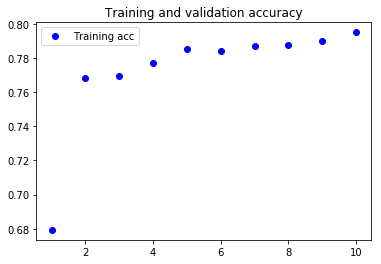

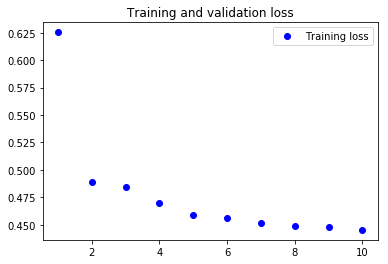

In [33]:
## Plot results
print(history.history)

acc = history.history['acc']
loss = history.history['loss']
# val_acc = history.history['val_loss']
# val_loss = history.history['val_acc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
# plt.plot(epochs, val_acc, 'b-', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
# plt.plot(epochs, val_loss, 'b-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Validation Xception 3/5

In [36]:
def evaluate(image_path):
    print(image_path)
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level=3)
    saving_test.load_second_level(image_path,
                                  input_level = 3,
                                  num_input_pixels = 64,
                                  output_level = 4,
                                  num_output_pixels = 64)
    
    loading_ds_test.test_part_2(image_path,
                                model,
                                tissue_regions,
                                slide_image_test,
                                tumor_mask,
                                image_depth,
                                image_width,
                                num_level_1 = 3, 
                                num_level_2 = 4)
    

tumor_101.tif
tumor_101.tif tumor_101_mask.tif
Precision: 0.8460523538298033
Recall: 0.7941691747745115
F1: 0.8192901848188561
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     30805159       419348
Reality 1       597305      2304617
           Predicted 0  Predicted 1
Reality 0    90.267748     1.228807
Reality 1     1.750271     6.753174


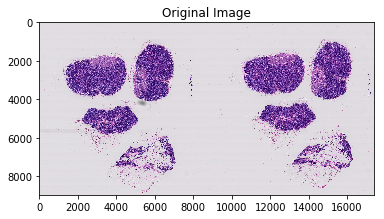

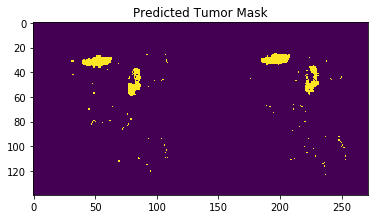

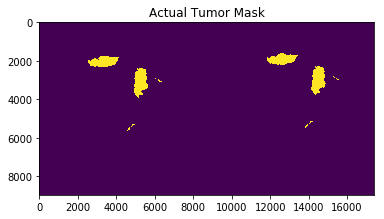

In [37]:
evaluate(validation_image_path_list[0])

tumor_023.tif
tumor_023.tif tumor_023_mask.tif
Precision: 0.024963177794311918
Recall: 0.11634819532908705
F1: 0.04110667983547326
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     15419234       128426
Reality 1        24972         3288
           Predicted 0  Predicted 1
Reality 0    98.994050     0.824516
Reality 1     0.160324     0.021110


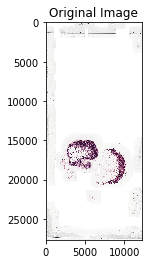

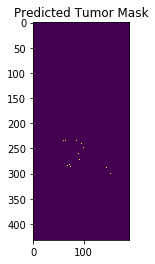

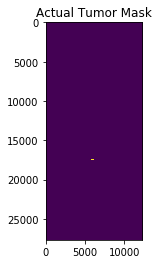

In [38]:
evaluate(validation_image_path_list[1])

tumor_091.tif
tumor_091.tif tumor_091_mask.tif
Precision: 0.5675150402773529
Recall: 0.7637444972609808
F1: 0.6511675250434649
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     12191537       424138
Reality 1       172166       556562
           Predicted 0  Predicted 1
Reality 0    91.360678     3.178396
Reality 1     1.290174     4.170752


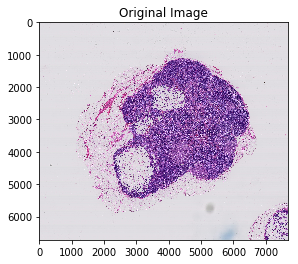

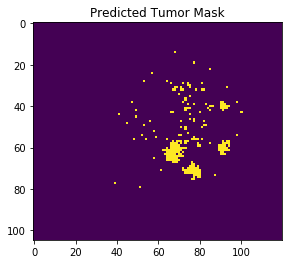

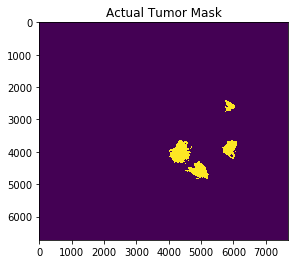

In [39]:
evaluate(validation_image_path_list[2])

tumor_110.tif
tumor_110.tif tumor_110_mask.tif
Precision: 0.9422237041973074
Recall: 0.9212325202590049
F1: 0.9316098830480583
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     15598106       882470
Reality 1      1230501     14391441
           Predicted 0  Predicted 1
Reality 0    48.588419     2.748912
Reality 1     3.833036    44.829633


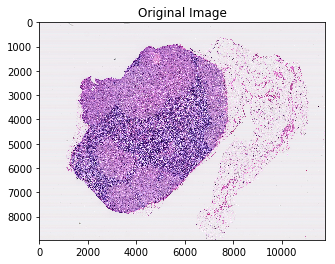

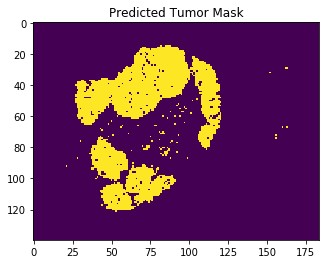

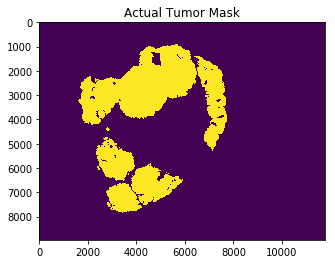

In [40]:
evaluate(validation_image_path_list[3])

# Threshold Evaluation

In [47]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from skimage.color import rgb2gray
import cv2
import os
import random
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd


def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [128, 128])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

def gen_image_paths(slide_path, level_num):
    img_num = slide_path.split('_')[1].strip(".tif")
    img_test_folder = 'tissue_only'

    data_root = pathlib.Path('data/' + img_num + '/level_' + str(level_num) +'/' + img_test_folder)

    all_image_paths = list(data_root.glob('*'))
    all_image_paths = [str(path) for path in all_image_paths]

    return  all_image_paths


def create_tf_dataset(all_image_paths_1, all_image_paths_2):
    path_ds_1 = tf.data.Dataset.from_tensor_slices(all_image_paths_1)
    image_ds_1 = path_ds_1.map(load_and_preprocess_image, num_parallel_calls=8)
    
    path_ds_2 = tf.data.Dataset.from_tensor_slices(all_image_paths_2)
    image_ds_2 = path_ds_2.map(load_and_preprocess_image, num_parallel_calls=8)
    
    image_test_ds = tf.data.Dataset.zip(((image_ds_1,image_ds_2),))

    ## Dataset parameters
    BATCH_SIZE = 4

    steps_per_epoch = int(np.ceil(len(all_image_paths_1) / BATCH_SIZE))
    # Setting a shuffle buffer size larger than the dataset ensures that the data is completely shuffled.
    ds = image_test_ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetches batches, asynchronously while the model is training.
    ds = ds.prefetch(1)

    return ds, steps_per_epoch


def tumor_predict_mask(test, all_image_paths, depth, width, threshold):

    test = test[0:len(all_image_paths), :]
    img_num = np.zeros(len(all_image_paths))
    for i in range(len(all_image_paths)):
        img_num[i] = int(all_image_paths[i].strip('.jpg').split('/')[-1].split('_')[-1])

    # depth, width = int(np.ceil(slide_image.shape[0] / pixel_num)), int(np.ceil(slide_image.shape[1] / pixel_num))

    predictions = np.zeros((depth, width))
    conf_threshold = threshold

    for i in range(len(test)):
        y = int(img_num[i] // width)
        x = int(np.mod(img_num[i], width))
        predictions[y, x] = int(test[i][1] > conf_threshold)

    return predictions

def heatmap_evaluation(predictions, mask_image, tissue_regions):

    # we only need to evaluate on areas which are tissue.
    # correct non tumor prediction count would be higher if we get credit for
    # predicting gray areas aren't tumors

    # find out the correct amount to scale predictions to match image
    scale = int(mask_image.shape[0]/predictions.shape[0])

    # create scaled prediction matix
    predictions_scaled = np.kron(predictions, np.ones((scale, scale)))

    # reshape everything to a 1D vector for easy computation
    predictions_scaled = predictions_scaled.reshape(-1)
    mask_image = mask_image.reshape(-1)
    tissue_regions = tissue_regions.reshape(-1)

    # only include entries that have tissue
    predictions_scaled = predictions_scaled[tissue_regions == 1]
    mask_image = mask_image[tissue_regions == 1]

    f = f1_score(mask_image, predictions_scaled)
    print('F1:', f)


def test_part_2(training_image_path, model, tissue_regions, slide_image_test,
                mask_image, depth, width, num_level_1, num_level_2, threshold_list):
    
    ## Generate image paths and labels    
    all_image_paths_1 = gen_image_paths(training_image_path, num_level_1)
    
    # create the second file path to mimic the 1st
    all_image_paths_2 = []
    for i in all_image_paths_1:
        split_str = i.split('/')
        split_str[2] = 'level_'+str(num_level_2)
        path_2_string = ''
        for j in split_str:
            if j == split_str[-1]:
                path_2_string = path_2_string + j
            else:
                path_2_string = path_2_string + j + '/'
        all_image_paths_2.append(path_2_string)    
    
    ## Create tf.Dataset for testing
    ds_test, steps_per_epoch_test = create_tf_dataset(all_image_paths_1, all_image_paths_2)

    ## Predict on test data
    test_predicts = model.predict(ds_test, steps = steps_per_epoch_test)
    ## Create mask containing test predictions
    
    for i in threshold_list:
        print('Threshold:', i)
        predictions = tumor_predict_mask(test_predicts, all_image_paths_1, depth, width, i)
        heatmap_evaluation(predictions, mask_image, tissue_regions)

def evaluate_threshold(image_path, threshold_list):
    print(image_path)
    image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path,
                                                                                                     num_pixels=64,
                                                                                                     num_level=3)
    saving_test.load_second_level(image_path,
                                  input_level = 3,
                                  num_input_pixels = 64,
                                  output_level = 4,
                                  num_output_pixels = 64)
    
    test_part_2(image_path,
                model,
                tissue_regions,
                slide_image_test,
                tumor_mask,
                image_depth,
                image_width,
                num_level_1 = 3, 
                num_level_2 = 4, 
                threshold_list=threshold_list)
    

   

In [48]:
evaluate_threshold(validation_image_path_list[3], threshold_list=[0.5,0.6,0.7,0.8,0.9])

tumor_110.tif
tumor_110.tif tumor_110_mask.tif
Threshold: 0.5
F1: 0.9309259124193766
Threshold: 0.6
F1: 0.933349793314955
Threshold: 0.7
F1: 0.9316098830480583
Threshold: 0.8
F1: 0.9231776328430331
Threshold: 0.9
F1: 0.8948752714023465


In [11]:
# image from train set
image_path = 'tumor_091.tif'
image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)

tumor_091.tif tumor_091_mask.tif


In [12]:
saving_test.load_second_level(image_path, input_level = 3, num_input_pixels = 64, 
                              output_level = 4, num_output_pixels = 64)

Precision: 0.26082809973501203
Recall: 0.7997565621191994
F1: 0.3933660213102932
Confusion Matrix:
           Predicted 0  Predicted 1
Reality 0     10964039      1651636
Reality 1       145923       582805
           Predicted 0  Predicted 1
Reality 0    82.162079    12.376994
Reality 1     1.093515     4.367412


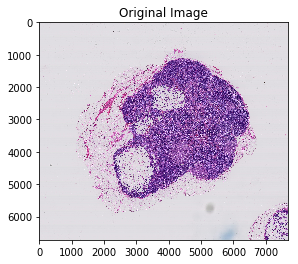

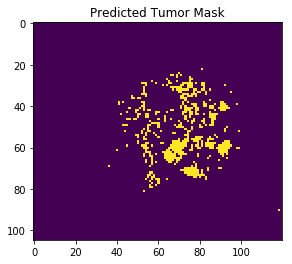

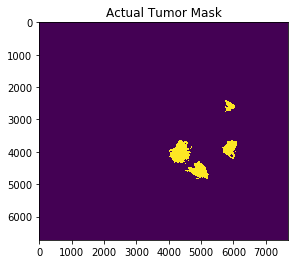

In [13]:
loading_ds_test.test_part_2(image_path, model, tissue_regions, slide_image_test, tumor_mask, image_depth, image_width, num_level = 3)

In [14]:
# new image from test set
# image_path = 'tumor_101.tif'
# image_depth, image_width, tumor_mask, tissue_regions, slide_image_test = saving_test.test_part_1(image_path, num_pixels=64, num_level=3)
# loading_ds_test.test_part_2(image_path,model,tissue_regions, slide_image_test, tumor_mask, image_depth, image_width)